In [1]:
from random import uniform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import PyDSTool_aux_functions as aux
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#----------------------------------------------------------------------------------------#
def HS(X,X0,nX,l):
    return l + (1.0-l)/(1.0 + (X/X0)**nX)
#----------------------------------------------------------------------------------------#
def func(eqs, p, k, x):
    return eval(eqs[k], p, {'N1': x[0], 'N2': x[5], 
                            'D1': x[1], 'D2': x[6], 
                            'J1': x[2], 'J2': x[7], 
                            'I1': x[3], 'I2': x[8],
                            'R1': x[4], 'R2': x[9]})
#----------------------------------------------------------------------------------------#
def euler_maruyama(eqs, keys, t, eps, dt, vlim, time=False):
    if time:
        import timeit
        start = timeit.default_timer()
    sdt = np.sqrt(dt)
    l = len(keys)

    y = np.zeros((int(t/dt)+1, 2*l))
    for j in range(l):
        y[0,j  ] = np.random.uniform(vlim[keys[j]+'1'][0],vlim[keys[j]+'1'][1],1)
        y[0,j+l] = np.random.uniform(vlim[keys[j]+'2'][0],vlim[keys[j]+'2'][1],1)

    g_rand = np.random.normal(loc=0, scale=1, size=(int(t/dt), 2*l))
    for i in range(int(t/dt)):
        for j in range(l):
            if keys[j] == 'I' or keys[j] == 'R':
                y[i+1,j]   = y[i,j  ] + dt*func(eqs, p, keys[j]+'1', y[i,:])
                y[i+1,j+l] = y[i,j+l] + dt*func(eqs, p, keys[j]+'2', y[i,:])
            else:
                y[i+1,j  ] = y[i,j  ] + dt*func(eqs, p, keys[j]+'1', y[i,:]) + sdt*eps*g_rand[i,j  ]
                y[i+1,j+l] = y[i,j+l] + dt*func(eqs, p, keys[j]+'2', y[i,:]) + sdt*eps*g_rand[i,j+l]
    if time:
        print timeit.default_timer() - start 
    return y

In [2]:
eqs  = {'N1': '''N0*HS(I1,I0,p,ln) - N1*( (kc*D1 + kt*(D2+Dt))*HS(I1,I0,pf,ldf) 
                                        + (kc*J1 + kt*(J2+Jt))*HS(I1,I0,pf,ljf) ) - g*N1'''
       ,'N2': '''N0*HS(I2,I0,p,ln) - N2*( (kc*D2 + kt*(D1+Dt))*HS(I2,I0,pf,ldf) 
                                        + (kc*J2 + kt*(J1+Jt))*HS(I2,I0,pf,ljf) ) - g*N2'''
       ,'D1': '''D0*HS(I1,I0,p,ld)*HS(kt*Vt*R1/gI,V0,p,ldv) - D1*( kc*N1*HS(I1,I0,pf,ldf) 
                                                             + kt*(N2+Nt)*HS(I2,I0,pf,ldf) ) - g*D1'''
       ,'D2': '''D0*HS(I2,I0,p,ld)*HS(kt*Vt*R2/gI,V0,p,ldv) - D2*( kc*N2*HS(I2,I0,pf,ldf) 
                                                             + kt*(N1+Nt)*HS(I1,I0,pf,ldf) ) - g*D2'''
       ,'J1': 'J0*HS(I1,I0,pj,lj) - J1*( kc*N1*HS(I1,I0,pf,ljf) + kt*(N2+Nt)*HS(I2,I0,pf,ljf) ) - g*J1'
       ,'J2': 'J0*HS(I2,I0,pj,lj) - J2*( kc*N2*HS(I2,I0,pf,ljf) + kt*(N1+Nt)*HS(I1,I0,pf,ljf) ) - g*J2'
       ,'I1': 'kt*N1*( (D2+Dt)*HS(I1,I0,pf,ldf) + (J2+Jt)*HS(I1,I0,pf,ljf) ) - gI*I1'
       ,'I2': 'kt*N2*( (D1+Dt)*HS(I2,I0,pf,ldf) + (J1+Jt)*HS(I2,I0,pf,ljf) ) - gI*I2'
       ,'R1': 'R0*HS(I1,I0,p ,lv) - kt*Vt*R1 - g*R1'
       ,'R2': 'R0*HS(I2,I0,p ,lv) - kt*Vt*R2 - g*R2' 
       }
p   =  {'g'  : 1.0e-1                                                  # degradation of a protein 
       ,'gI' : 5.0e-1                                                  # degradation of NICD 
       ,'kc' : 5.0e-4                                                  # rate of cis interaction
       ,'kt' : 2.5e-5                                                  # rate of trans interaction
       ,'p'  : 2.0e+0, 'pj' : 5.0e+0                                   # hill coeficient
       ,'I0' : 2.0e+2, 'V0' : 2.0e+2                                   # hill factor
       ,'Nt' : 0.0e+3, 'Dt' : 0.0e+3, 'Jt' : 0.0e+3, 'Vt' : 1.0e+3     # external proteins
       ,'N0' : 1.2e+3, 'D0' : 1.0e+3, 'J0' : 1.0e+3, 'R0' : 1.0e+3     # production rate
       ,'ln' : 2.0e+0, 'ld' : 0.0e+0, 'lj' : 2.0e+0                    # lambda of shifted hill function
       ,'lv' : 0.0e+0, 'ldv': 2.0e+0
       ,'pf' : 1.0
       ,'ldf': 3.0,    'ljf': 0.3
       ,'HS' : HS
       }
vlim = {'N1': [0, 2.0e+1],'D1': [0, 2.0e+1],'J1': [0, 5.0e+1],'R1': [0, 1.0e+1],'I1': [0, 1.0e+1],
        'N2': [0, 2.0e+1],'D2': [0, 2.0e+1],'J2': [0, 5.0e+1],'R2': [0, 1.0e+1],'I2': [0, 1.0e+1]
       }

910.955457926
830.967648029
840.609200001
957.970551014

PyDSTool_aux_functions.py:368: RuntimeWarning: divide by zero encountered in log
  V = -np.log(H/npoints)
PyDSTool_aux_functions.py:370: RuntimeWarning: invalid value encountered in greater
  V[V>cut]=float('NaN')
PyDSTool_aux_functions.py:379: RuntimeWarning: invalid value encountered in greater
  pc.set_clim(np.min(V[V>0]),np.max(V[V>0]))


/usr/lib/pymodules/python2.7/matplotlib/colors.py:576: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


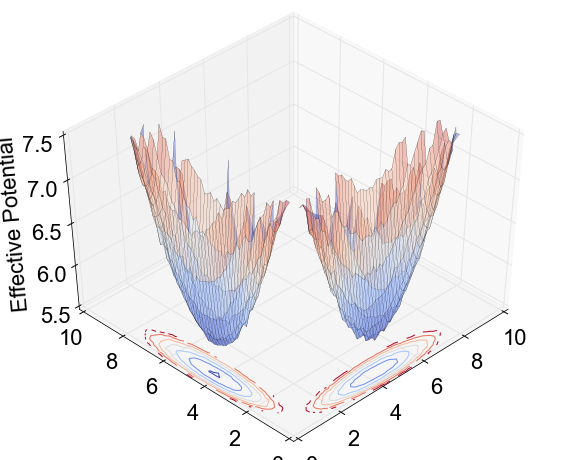

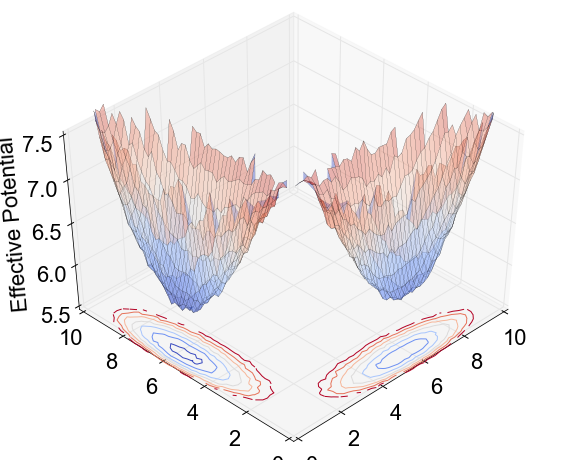

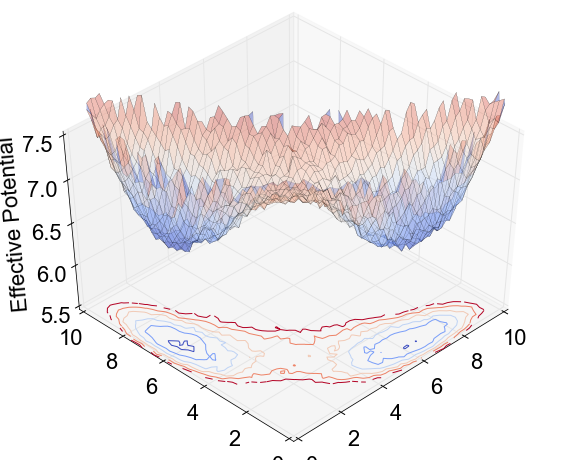

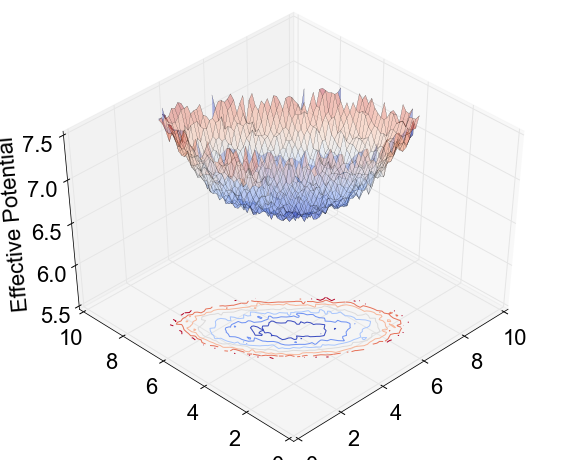

In [3]:
dt = 0.1
eps= 800
#t  = 1000000
t  = 100000
keys = ['N', 'D', 'J', 'I', 'R']
i = 1 # selecting proteins levels. i=0 (Notch), i=1 (Delta), i=2 (Jagged), i=3 (NICD)

#------------------------ Fig. 4 ------------------------------------------
p['J0'] = 1000
J1 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
p['J0'] = 1400
J2 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
p['J0'] = 1800
J3 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
eps= 500
p['J0'] = 2200
J4 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
eps= 800

offset =5.6
cut=8.0
xylim=[0, 10]
zlim=[5.5, 7.5]
aux.plot_3Dpotential(J1[:,i], J1[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_J01000')
aux.plot_3Dpotential(J2[:,i], J2[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_J01400')
aux.plot_3Dpotential(J3[:,i], J3[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset, 
                     cut=cut)#, fig_name='./figures/3DPotential_J01800')
aux.plot_3Dpotential(J4[:,i], J4[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset, 
                     cut=cut)#, fig_name='./figures/3DPotential_J02200')

1028.56606078
813.011581898
685.461756945
914.560226202


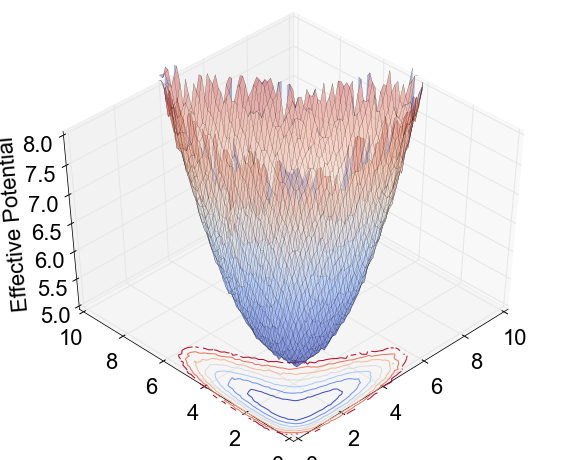

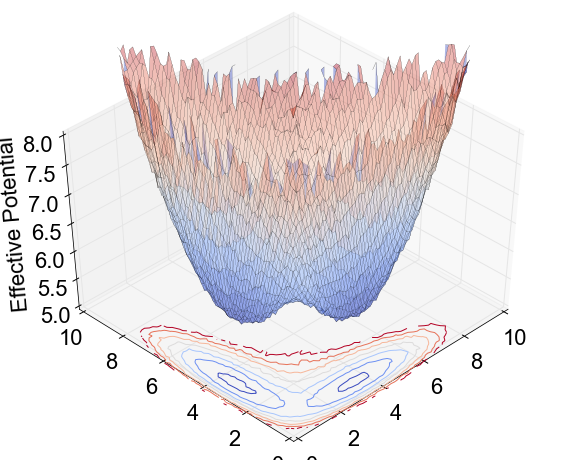

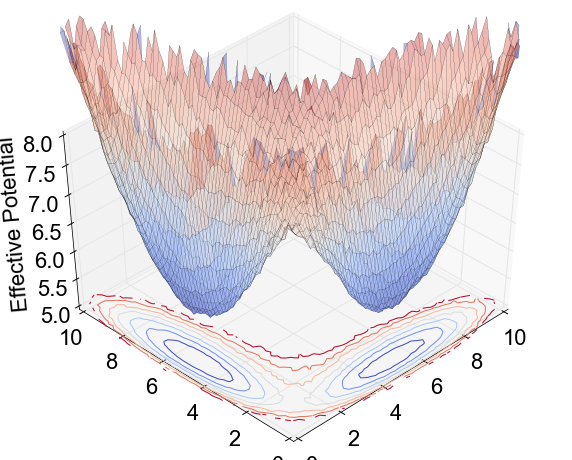

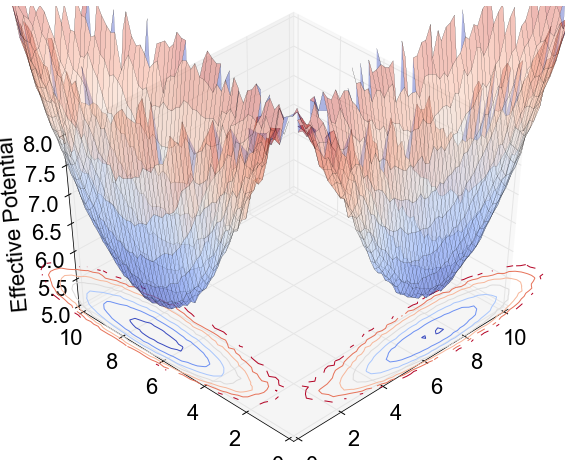

In [4]:
#------------------------ Fig. S7 ------------------------------------------
p['J0'] = 1200
p['D0'] = 600
D1 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
p['D0'] = 800
D2 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
p['D0'] = 1000
D3 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
p['D0'] = 1200
D4 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)

offset =5.2
cut=9.85
xylim=[0, 10]
zlim=[5, 8.0]
aux.plot_3Dpotential(D1[:,i], D1[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_D0600')
aux.plot_3Dpotential(D2[:,i], D2[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_D0800')
aux.plot_3Dpotential(D3[:,i], D3[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_D01000')
aux.plot_3Dpotential(D4[:,i], D4[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_D01200')

698.585282087
589.917382002


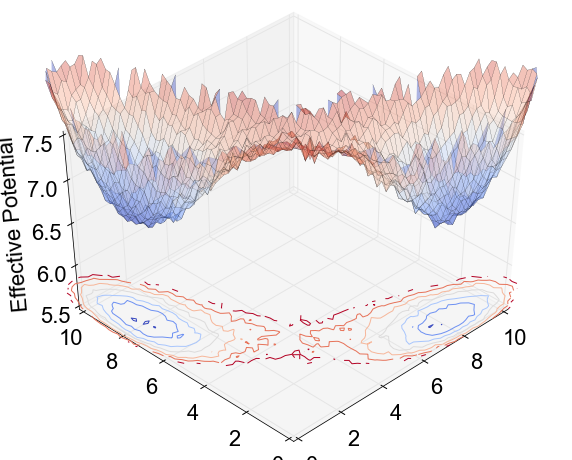

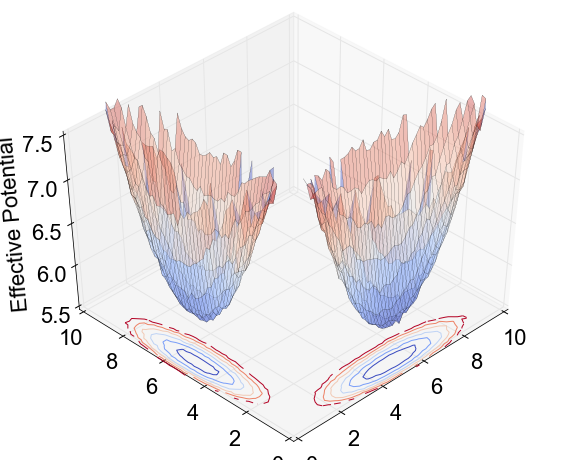

In [5]:
#------------------------ Fig. 6A,B ------------------------------------------
p['J0'] = 1200
p['D0'] = 1000

p['ldf'] = 1.0
p['ljf'] = 1.0
f1 = euler_maruyama(eqs, keys, t, eps, dt,  vlim, time=True)
p['ldf'] = 3.0
p['ljf'] = 0.3
f2 = euler_maruyama(eqs, keys, t, eps, dt,  vlim, time=True)

offset =5.6
cut=8.1
xylim=[0, 10]
zlim=[5.5, 7.5]
aux.plot_3Dpotential(f1[:,i], f1[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_lowFng')
aux.plot_3Dpotential(f2[:,i], f2[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_highFng')

595.22055006
596.160815001


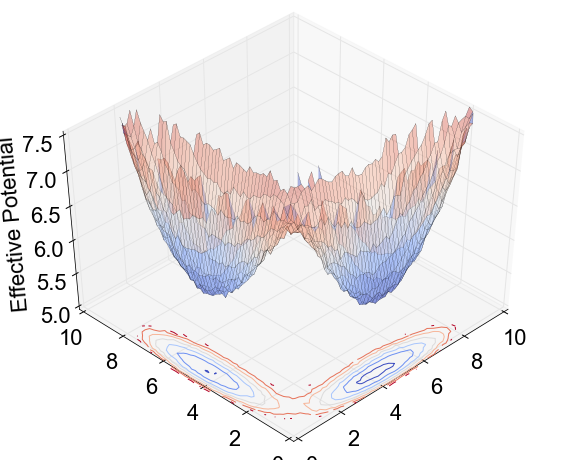

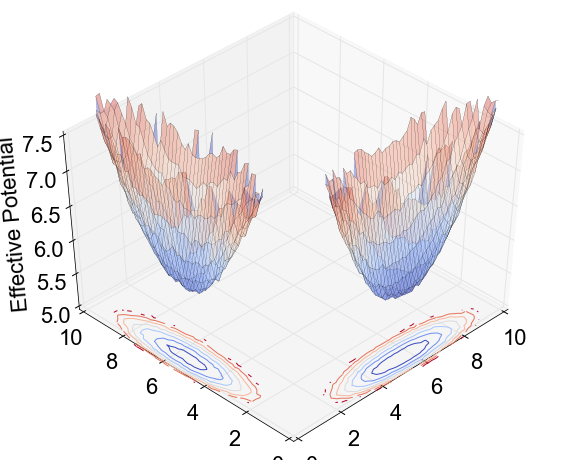

In [6]:
#------------------------ Fig. 7 ------------------------------------------
p['kc'] = 4.5e-4
k1 = euler_maruyama(eqs, keys, t, eps, dt,  vlim, time=True)
p['kc'] = 5.5e-4
k2 = euler_maruyama(eqs, keys, t, eps, dt,  vlim, time=True)

offset =5.1
cut=8.2
xylim=[0, 10]
zlim=[5, 7.5]
aux.plot_3Dpotential(k1[:,i], k1[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset, 
                     cut=cut)#, fig_name='./figures/3DPotential_lowCis')
aux.plot_3Dpotential(k2[:,i], k2[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_highCis')

599.748702049
598.06840086


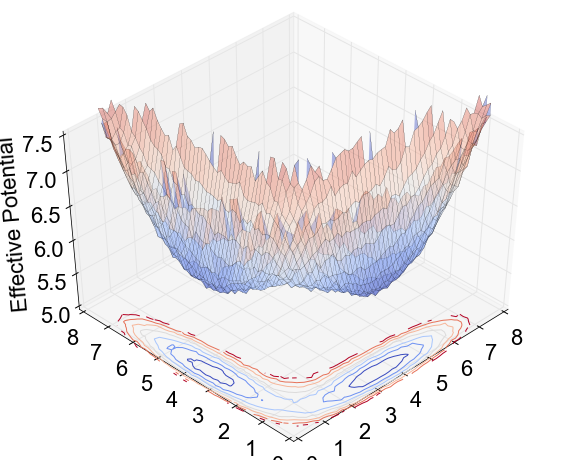

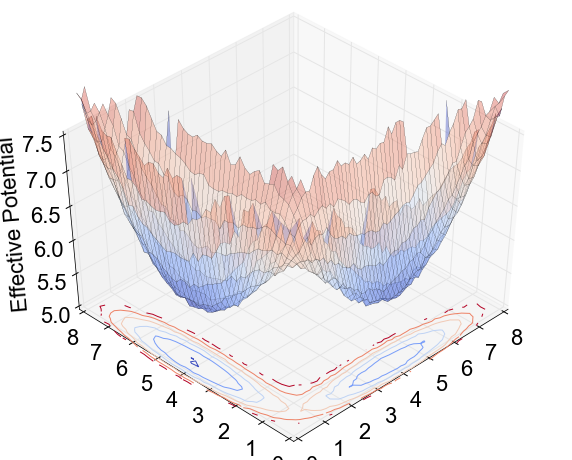

598.619909048
600.224020004


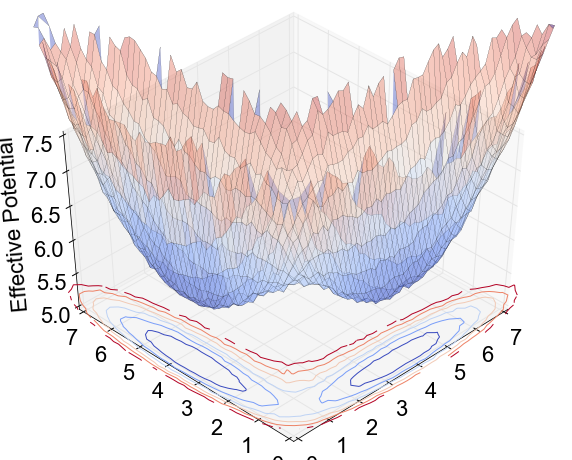

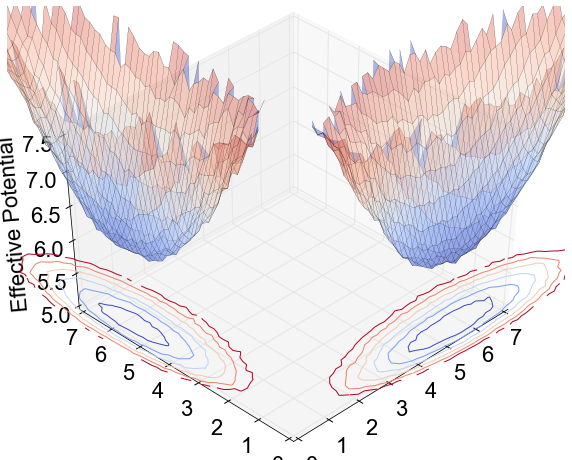

In [7]:
#------------------------ Fig. S8 ------------------------------------------
eqs  = {'N1': '''N0*HS(I1,I0,p,ln) - N1*( (kcD*D1 + kt*(D2+Dt))*HS(I1,I0,pf,ldf) 
                                        + (kcJ*J1 + kt*(J2+Jt))*HS(I1,I0,pf,ljf) ) - g*N1'''
       ,'N2': '''N0*HS(I2,I0,p,ln) - N2*( (kcD*D2 + kt*(D1+Dt))*HS(I2,I0,pf,ldf) 
                                        + (kcJ*J2 + kt*(J1+Jt))*HS(I2,I0,pf,ljf) ) - g*N2'''
       ,'D1': '''D0*HS(I1,I0,p,ld)*HS(kt*Vt*R1/gI,V0,p,ldv) - D1*( kcD*N1*HS(I1,I0,pf,ldf) 
                                                             + kt*(N2+Nt)*HS(I2,I0,pf,ldf) ) - g*D1'''
       ,'D2': '''D0*HS(I2,I0,p,ld)*HS(kt*Vt*R2/gI,V0,p,ldv) - D2*( kcD*N2*HS(I2,I0,pf,ldf) 
                                                             + kt*(N1+Nt)*HS(I1,I0,pf,ldf) ) - g*D2'''
       ,'J1': 'J0*HS(I1,I0,pj,lj) - J1*( kcJ*N1*HS(I1,I0,pf,ljf) + kt*(N2+Nt)*HS(I2,I0,pf,ljf) ) - g*J1'
       ,'J2': 'J0*HS(I2,I0,pj,lj) - J2*( kcJ*N2*HS(I2,I0,pf,ljf) + kt*(N1+Nt)*HS(I1,I0,pf,ljf) ) - g*J2'
       ,'I1': 'kt*N1*( (D2+Dt)*HS(I1,I0,pf,ldf) + (J2+Jt)*HS(I1,I0,pf,ljf) ) - gI*I1'
       ,'I2': 'kt*N2*( (D1+Dt)*HS(I2,I0,pf,ldf) + (J1+Jt)*HS(I2,I0,pf,ljf) ) - gI*I2'
       ,'R1': 'R0*HS(I1,I0,p ,lv) - kt*Vt*R1 - g*R1'
       ,'R2': 'R0*HS(I2,I0,p ,lv) - kt*Vt*R2 - g*R2' 
       }

p['kcJ'] = 4.0e-4
p['kcD'] = 4.0e-4
k1 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
p['kcD'] = 6.0e-4
k2 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)

offset =5.1
cut=8.2
xylim=[0, 8]
zlim=[5, 7.5]
aux.plot_3Dpotential(k1[:,i], k1[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_lowkcD')
aux.plot_3Dpotential(k2[:,i], k2[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_highkcD')

p['kcD'] = 5.0e-4
p['kcJ'] = 4.0e-4
k3 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
p['kcJ'] = 6.0e-4
k4 = euler_maruyama(eqs, keys, t, eps, dt, vlim, time=True)
cut=8.8
xylim=[0, 7]
aux.plot_3Dpotential(k3[:,i], k3[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_lowkcJ')
aux.plot_3Dpotential(k4[:,i], k4[:,i+len(keys)], float(t/dt), xlim=xylim, ylim=xylim, zlim=zlim, offset=offset,
                     cut=cut)#, fig_name='./figures/3DPotential_highkcJ')